INFO:root:Total parameters: 40834


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1000_hypothyroid.csv
Count of 0's: 3481, Count of 1's: 291


  0%|          | 0/321 [00:00<?, ?it/s]
INFO:root:Total parameters: 47490


Erro com dataset_1000_hypothyroid.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1002_ipums_la_98-small.csv
Count of 0's: 6694, Count of 1's: 791


  0%|          | 0/637 [00:00<?, ?it/s]
INFO:root:Total parameters: 48770


Erro com dataset_1002_ipums_la_98-small.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1004_synthetic_control.csv
Count of 0's: 500, Count of 1's: 100


100%|██████████| 51/51 [00:00<00:00, 392.80it/s]
INFO:root:Epoch:0, train loss: 10.610194742419472, train accuracy: 0.8254901960784313, elapsed: 0.14133024215698242 sec.
100%|██████████| 51/51 [00:00<00:00, 348.59it/s]
INFO:root:Epoch:1, train loss: 6.120112919957328, train accuracy: 0.8254901960784313, elapsed: 0.15833139419555664 sec.
100%|██████████| 51/51 [00:00<00:00, 354.46it/s]
INFO:root:Epoch:2, train loss: 6.214497708042924, train accuracy: 0.8254901960784313, elapsed: 0.15643572807312012 sec.
100%|██████████| 51/51 [00:00<00:00, 361.85it/s]
INFO:root:Epoch:3, train loss: 5.266229876403621, train accuracy: 0.8254901960784313, elapsed: 0.15499496459960938 sec.
100%|██████████| 51/51 [00:00<00:00, 342.31it/s]
INFO:root:Epoch:4, train loss: 5.634411446440922, train accuracy: 0.8254901960784313, elapsed: 0.1615445613861084 sec.
100%|██████████| 51/51 [00:00<00:00, 329.50it/s]
INFO:root:Epoch:5, train loss: 5.279733012097944, train accuracy: 0.8254901960784313, elapsed: 0.168318033

Roc Score Area under the curve 0.9988492520138089


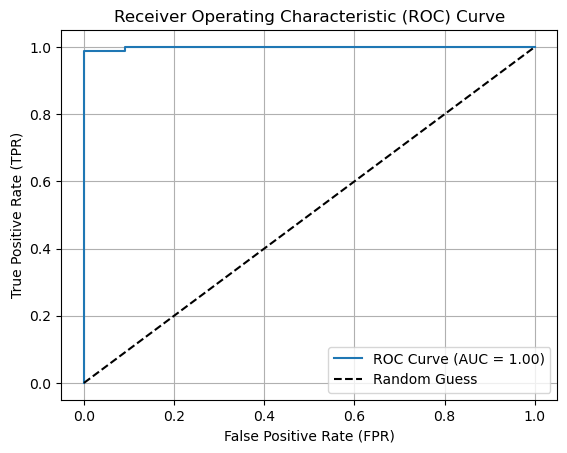

INFO:root:Total parameters: 33922


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1013_analcatdata_challenger.csv
Count of 0's: 129, Count of 1's: 9


100%|██████████| 12/12 [00:00<00:00, 468.75it/s]
INFO:root:Epoch:0, train loss: 13.710560484350871, train accuracy: 0.9316239316239316, elapsed: 0.03160881996154785 sec.
100%|██████████| 12/12 [00:00<00:00, 568.18it/s]
INFO:root:Epoch:1, train loss: 6.454600864259391, train accuracy: 0.9316239316239316, elapsed: 0.027146100997924805 sec.
100%|██████████| 12/12 [00:00<00:00, 532.27it/s]
INFO:root:Epoch:2, train loss: 4.410471965532439, train accuracy: 0.9316239316239316, elapsed: 0.02855682373046875 sec.
100%|██████████| 12/12 [00:00<00:00, 461.99it/s]
INFO:root:Epoch:3, train loss: 4.419318465927318, train accuracy: 0.9316239316239316, elapsed: 0.032974958419799805 sec.
100%|██████████| 12/12 [00:00<00:00, 459.62it/s]
INFO:root:Epoch:4, train loss: 2.712261264756483, train accuracy: 0.9316239316239316, elapsed: 0.03316092491149902 sec.
100%|██████████| 12/12 [00:00<00:00, 419.73it/s]
INFO:root:Epoch:5, train loss: 2.3187213896941548, train accuracy: 0.9316239316239316, elapsed: 0.03610

Roc Score Area under the curve 0.5


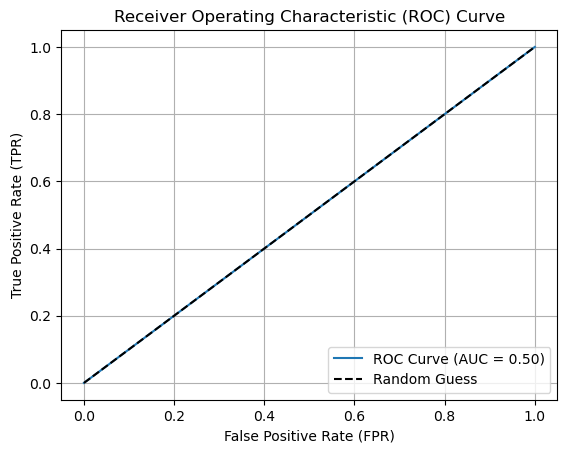

INFO:root:Total parameters: 34434


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1014_analcatdata_dmft.csv
Count of 0's: 642, Count of 1's: 155


  0%|          | 0/68 [00:00<?, ?it/s]
INFO:root:Total parameters: 36482


Erro com dataset_1014_analcatdata_dmft.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1016_vowel.csv
Count of 0's: 900, Count of 1's: 90


  0%|          | 0/85 [00:00<?, ?it/s]
INFO:root:Total parameters: 47746


Erro com dataset_1016_vowel.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1018_ipums_la_99-small.csv
Count of 0's: 8276, Count of 1's: 568


  0%|          | 0/752 [00:00<?, ?it/s]
INFO:root:Total parameters: 49794


Erro com dataset_1018_ipums_la_99-small.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1020_mfeat-karhunen.csv
Count of 0's: 1800, Count of 1's: 200


100%|██████████| 170/170 [00:00<00:00, 334.49it/s]
INFO:root:Epoch:0, train loss: 1.286651611683796, train accuracy: 0.8958823529411765, elapsed: 0.5413210391998291 sec.
100%|██████████| 170/170 [00:00<00:00, 369.49it/s]
INFO:root:Epoch:1, train loss: 0.512675532959516, train accuracy: 0.9605882352941176, elapsed: 0.4958775043487549 sec.
100%|██████████| 170/170 [00:00<00:00, 318.43it/s]
INFO:root:Epoch:2, train loss: 0.3395077093716262, train accuracy: 0.9729411764705882, elapsed: 0.5675151348114014 sec.
100%|██████████| 170/170 [00:00<00:00, 318.11it/s]
INFO:root:Epoch:3, train loss: 0.30461877249589003, train accuracy: 0.9823529411764705, elapsed: 0.567986249923706 sec.
100%|██████████| 170/170 [00:00<00:00, 345.99it/s]
INFO:root:Epoch:4, train loss: 0.2403113298879921, train accuracy: 0.9882352941176471, elapsed: 0.5203611850738525 sec.
100%|██████████| 170/170 [00:00<00:00, 319.52it/s]
INFO:root:Epoch:5, train loss: 0.19748324958922764, train accuracy: 0.9888235294117647, elapsed:

Roc Score Area under the curve 0.9767822105951602


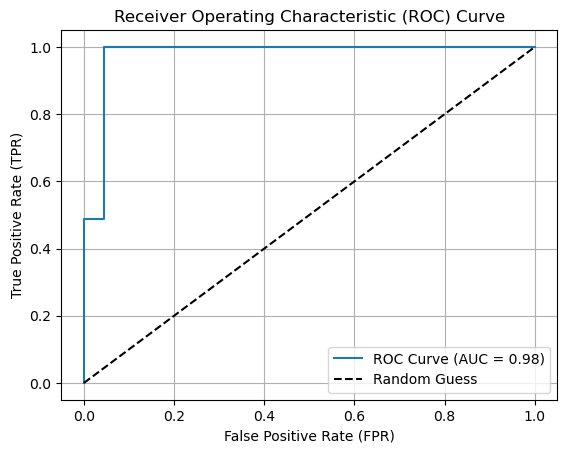

INFO:root:Total parameters: 35970


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1021_page-blocks.csv
Count of 0's: 4913, Count of 1's: 560


100%|██████████| 466/466 [00:01<00:00, 444.65it/s]
INFO:root:Epoch:0, train loss: 3.983816902814225, train accuracy: 0.9082115219260534, elapsed: 1.1420223712921143 sec.
100%|██████████| 466/466 [00:00<00:00, 533.50it/s]
INFO:root:Epoch:1, train loss: 3.152897740419898, train accuracy: 0.9294926913155632, elapsed: 0.9414267539978027 sec.
100%|██████████| 466/466 [00:00<00:00, 541.32it/s]
INFO:root:Epoch:2, train loss: 2.88695303234526, train accuracy: 0.9241186586414445, elapsed: 0.9414551258087158 sec.
100%|██████████| 466/466 [00:00<00:00, 549.00it/s]
INFO:root:Epoch:3, train loss: 2.779857164837261, train accuracy: 0.9331470335339639, elapsed: 0.9227156639099121 sec.
100%|██████████| 466/466 [00:01<00:00, 462.16it/s]
INFO:root:Epoch:4, train loss: 2.4847708081367728, train accuracy: 0.9340068787618229, elapsed: 1.086895227432251 sec.
100%|██████████| 466/466 [00:00<00:00, 552.89it/s]
INFO:root:Epoch:5, train loss: 2.366846552804898, train accuracy: 0.9346517626827171, elapsed: 0.930

Roc Score Area under the curve 0.7779517549299269


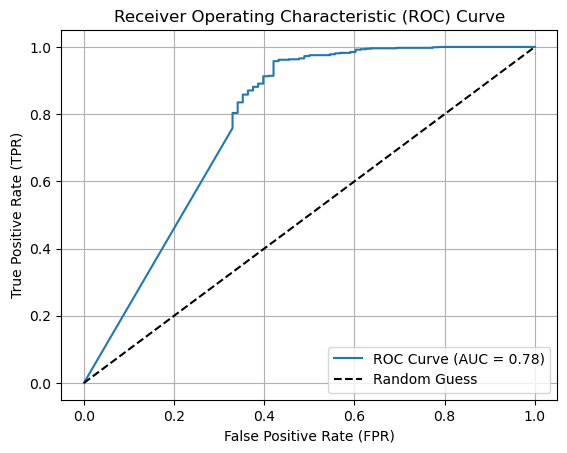

INFO:root:Total parameters: 94850


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1022_mfeat-pixel.csv
Count of 0's: 1800, Count of 1's: 200


100%|██████████| 170/170 [00:01<00:00, 159.55it/s]
INFO:root:Epoch:0, train loss: 3.5805934331136937, train accuracy: 0.8952941176470588, elapsed: 1.1250636577606201 sec.
100%|██████████| 170/170 [00:00<00:00, 172.51it/s]
INFO:root:Epoch:1, train loss: 1.0926154957263021, train accuracy: 0.8952941176470588, elapsed: 1.0274772644042969 sec.
100%|██████████| 170/170 [00:01<00:00, 161.95it/s]
INFO:root:Epoch:2, train loss: 0.6243309177053634, train accuracy: 0.9047058823529411, elapsed: 1.0887274742126465 sec.
100%|██████████| 170/170 [00:00<00:00, 176.46it/s]
INFO:root:Epoch:3, train loss: 0.4086045957245445, train accuracy: 0.918235294117647, elapsed: 1.0043668746948242 sec.
100%|██████████| 170/170 [00:01<00:00, 164.56it/s]
INFO:root:Epoch:4, train loss: 0.44862908686183445, train accuracy: 0.9376470588235294, elapsed: 1.0740528106689453 sec.
100%|██████████| 170/170 [00:00<00:00, 178.83it/s]
INFO:root:Epoch:5, train loss: 0.3498382075884199, train accuracy: 0.9641176470588235, elapsed

Roc Score Area under the curve 0.9798888162197515


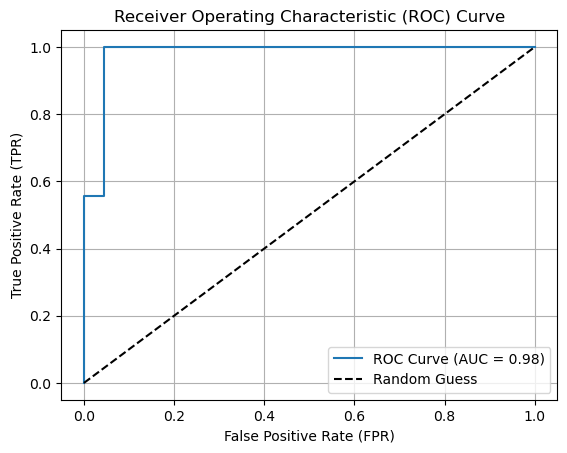

INFO:root:Total parameters: 42370


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1023_soybean.csv
Count of 0's: 591, Count of 1's: 92


  0%|          | 0/58 [00:00<?, ?it/s]

Erro com dataset_1023_soybean.csv: can't multiply sequence by non-int of type 'float'



INFO:root:Total parameters: 447362


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1039_hiva_agnostic.csv
Count of 0's: 4080, Count of 1's: 149


100%|██████████| 360/360 [00:16<00:00, 21.69it/s]
INFO:root:Epoch:0, train loss: 0.2690941748536317, train accuracy: 0.964663327768503, elapsed: 16.743014812469482 sec.
100%|██████████| 360/360 [00:17<00:00, 21.16it/s]
INFO:root:Epoch:1, train loss: 0.21245721809440132, train accuracy: 0.964663327768503, elapsed: 17.150310516357422 sec.
100%|██████████| 360/360 [00:17<00:00, 21.16it/s]
INFO:root:Epoch:2, train loss: 0.19276748492851, train accuracy: 0.964663327768503, elapsed: 17.18028450012207 sec.
100%|██████████| 360/360 [00:17<00:00, 20.83it/s]
INFO:root:Epoch:3, train loss: 0.17194549318270963, train accuracy: 0.964663327768503, elapsed: 17.432900190353394 sec.
100%|██████████| 360/360 [00:16<00:00, 21.48it/s]
INFO:root:Epoch:4, train loss: 0.16871425751154684, train accuracy: 0.964663327768503, elapsed: 16.914608001708984 sec.
100%|██████████| 360/360 [00:21<00:00, 17.00it/s]
INFO:root:Epoch:5, train loss: 0.16642596283505254, train accuracy: 0.964663327768503, elapsed: 21.341927

Roc Score Area under the curve 0.6525285481239804


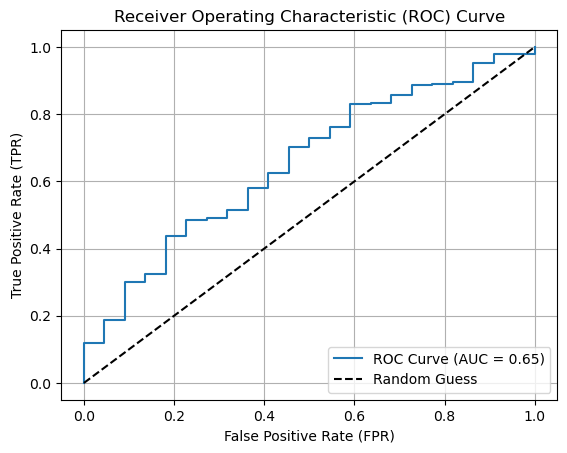

INFO:root:Total parameters: 57474


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1045_kc1-top5.csv
Count of 0's: 137, Count of 1's: 8


100%|██████████| 13/13 [00:00<00:00, 182.53it/s]
INFO:root:Epoch:0, train loss: 5.195136606337375, train accuracy: 0.9105691056910569, elapsed: 0.07223153114318848 sec.
100%|██████████| 13/13 [00:00<00:00, 257.32it/s]
INFO:root:Epoch:1, train loss: 6.636379342655275, train accuracy: 0.9105691056910569, elapsed: 0.058522701263427734 sec.
100%|██████████| 13/13 [00:00<00:00, 325.02it/s]
INFO:root:Epoch:2, train loss: 5.416172609176652, train accuracy: 0.9186991869918699, elapsed: 0.04799652099609375 sec.
100%|██████████| 13/13 [00:00<00:00, 321.74it/s]
INFO:root:Epoch:3, train loss: 6.20805319799744, train accuracy: 0.926829268292683, elapsed: 0.04838919639587402 sec.
100%|██████████| 13/13 [00:00<00:00, 269.15it/s]
INFO:root:Epoch:4, train loss: 5.442618551527945, train accuracy: 0.926829268292683, elapsed: 0.05629849433898926 sec.
100%|██████████| 13/13 [00:00<00:00, 320.44it/s]
INFO:root:Epoch:5, train loss: 8.00851221983214, train accuracy: 0.9349593495934959, elapsed: 0.048547983169

Roc Score Area under the curve 0.40476190476190477


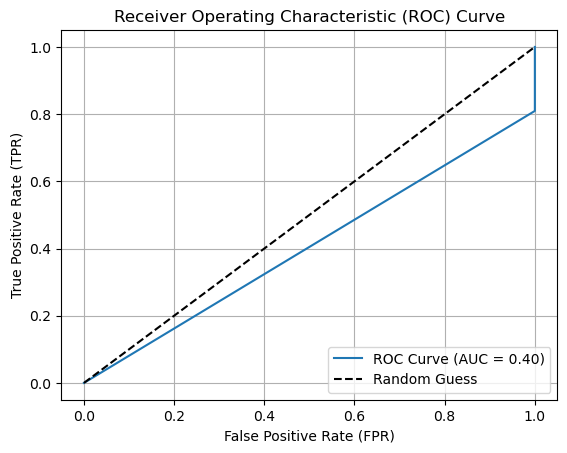

INFO:root:Total parameters: 42882


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1049_pc4.csv
Count of 0's: 1280, Count of 1's: 178


100%|██████████| 124/124 [00:00<00:00, 401.27it/s]
INFO:root:Epoch:0, train loss: 10.310221399227862, train accuracy: 0.8789346246973365, elapsed: 0.33501625061035156 sec.
100%|██████████| 124/124 [00:00<00:00, 434.21it/s]
INFO:root:Epoch:1, train loss: 8.74367715248472, train accuracy: 0.8789346246973365, elapsed: 0.3089721202850342 sec.
100%|██████████| 124/124 [00:00<00:00, 412.28it/s]
INFO:root:Epoch:2, train loss: 8.050559856050802, train accuracy: 0.8789346246973365, elapsed: 0.3256690502166748 sec.
100%|██████████| 124/124 [00:00<00:00, 434.20it/s]
INFO:root:Epoch:3, train loss: 7.764584708010727, train accuracy: 0.8789346246973365, elapsed: 0.3083913326263428 sec.
100%|██████████| 124/124 [00:00<00:00, 434.51it/s]
INFO:root:Epoch:4, train loss: 7.395889650522383, train accuracy: 0.8789346246973365, elapsed: 0.3109583854675293 sec.
100%|██████████| 124/124 [00:00<00:00, 424.29it/s]
INFO:root:Epoch:5, train loss: 8.296624961578724, train accuracy: 0.8789346246973365, elapsed: 0.3

Roc Score Area under the curve 0.4434367988032909


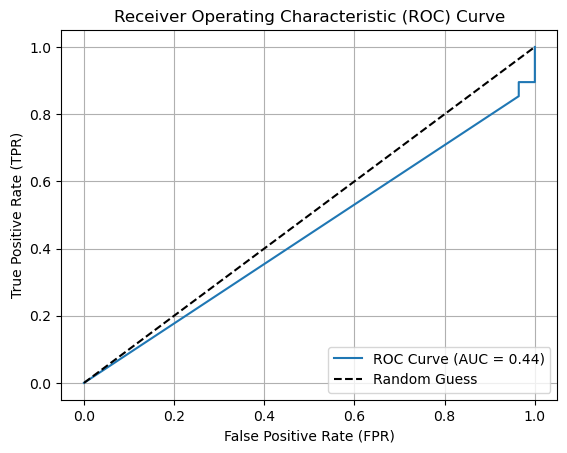

INFO:root:Total parameters: 42882


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1050_pc3.csv
Count of 0's: 1403, Count of 1's: 160


100%|██████████| 133/133 [00:00<00:00, 402.53it/s]
INFO:root:Epoch:0, train loss: 7.73130883368445, train accuracy: 0.8998493975903614, elapsed: 0.3554084300994873 sec.
100%|██████████| 133/133 [00:00<00:00, 438.83it/s]
INFO:root:Epoch:1, train loss: 7.014751041810093, train accuracy: 0.8998493975903614, elapsed: 0.3301200866699219 sec.
100%|██████████| 133/133 [00:00<00:00, 417.21it/s]
INFO:root:Epoch:2, train loss: 6.711083908381855, train accuracy: 0.8998493975903614, elapsed: 0.3447761535644531 sec.
100%|██████████| 133/133 [00:00<00:00, 439.48it/s]
INFO:root:Epoch:3, train loss: 7.516108766035167, train accuracy: 0.8998493975903614, elapsed: 0.3306093215942383 sec.
100%|██████████| 133/133 [00:00<00:00, 412.53it/s]
INFO:root:Epoch:4, train loss: 6.52673519556598, train accuracy: 0.8998493975903614, elapsed: 0.3499312400817871 sec.
100%|██████████| 133/133 [00:00<00:00, 386.20it/s]
INFO:root:Epoch:5, train loss: 6.358785756355826, train accuracy: 0.8998493975903614, elapsed: 0.3713

Roc Score Area under the curve 0.37464387464387466


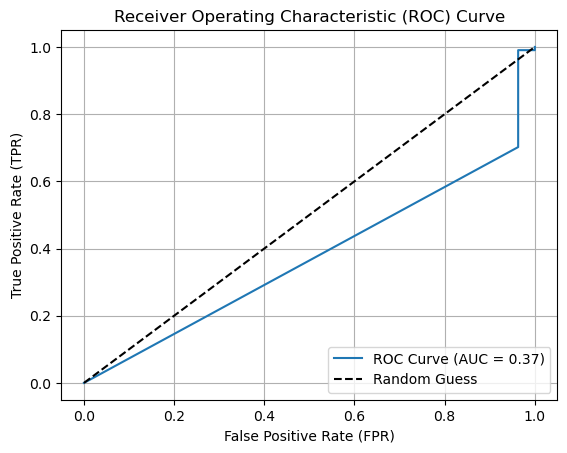

INFO:root:Total parameters: 43138


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1056_mc1.csv
Count of 0's: 9398, Count of 1's: 68


100%|██████████| 805/805 [00:01<00:00, 409.84it/s]
INFO:root:Epoch:0, train loss: 1.4260803389362238, train accuracy: 0.992418593089734, elapsed: 2.09926176071167 sec.
100%|██████████| 805/805 [00:01<00:00, 407.72it/s]
INFO:root:Epoch:1, train loss: 0.6052519404730485, train accuracy: 0.992418593089734, elapsed: 2.113861083984375 sec.
100%|██████████| 805/805 [00:01<00:00, 416.38it/s]
INFO:root:Epoch:2, train loss: 0.5430703700693391, train accuracy: 0.992418593089734, elapsed: 2.071385145187378 sec.
100%|██████████| 805/805 [00:01<00:00, 415.26it/s]
INFO:root:Epoch:3, train loss: 0.5506989219663982, train accuracy: 0.992418593089734, elapsed: 2.075575590133667 sec.
100%|██████████| 805/805 [00:01<00:00, 405.97it/s]
INFO:root:Epoch:4, train loss: 0.5320940319910815, train accuracy: 0.992418593089734, elapsed: 2.1202683448791504 sec.
100%|██████████| 805/805 [00:01<00:00, 417.29it/s]
INFO:root:Epoch:5, train loss: 0.54781864437539, train accuracy: 0.992418593089734, elapsed: 2.058661699

Roc Score Area under the curve 0.1818825194621373


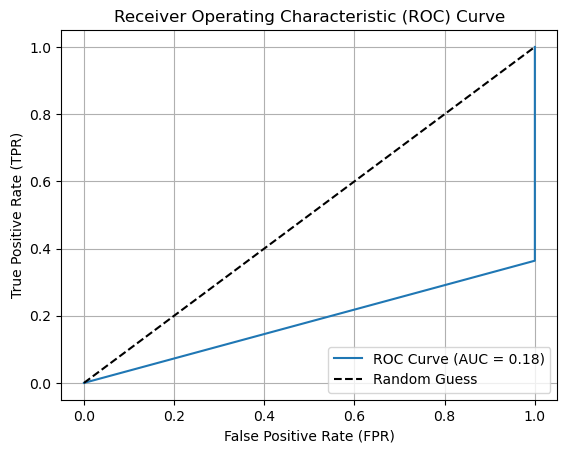

INFO:root:Total parameters: 40834


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1059_ar1.csv
Count of 0's: 112, Count of 1's: 9


100%|██████████| 11/11 [00:00<00:00, 289.38it/s]
INFO:root:Epoch:0, train loss: 9.844862061016485, train accuracy: 0.9313725490196079, elapsed: 0.047525644302368164 sec.
100%|██████████| 11/11 [00:00<00:00, 305.58it/s]
INFO:root:Epoch:1, train loss: 8.375087754297807, train accuracy: 0.9313725490196079, elapsed: 0.11711525917053223 sec.
100%|██████████| 11/11 [00:00<00:00, 281.03it/s]
INFO:root:Epoch:2, train loss: 6.661107683830665, train accuracy: 0.9313725490196079, elapsed: 0.04622340202331543 sec.
100%|██████████| 11/11 [00:00<00:00, 407.27it/s]
INFO:root:Epoch:3, train loss: 3.6752144767930557, train accuracy: 0.9313725490196079, elapsed: 0.03351759910583496 sec.
100%|██████████| 11/11 [00:00<00:00, 439.99it/s]
INFO:root:Epoch:4, train loss: 2.9521795944230855, train accuracy: 0.9313725490196079, elapsed: 0.03201627731323242 sec.
100%|██████████| 11/11 [00:00<00:00, 407.20it/s]
INFO:root:Epoch:5, train loss: 6.096664724253566, train accuracy: 0.9313725490196079, elapsed: 0.034086

Roc Score Area under the curve 0.4117647058823529


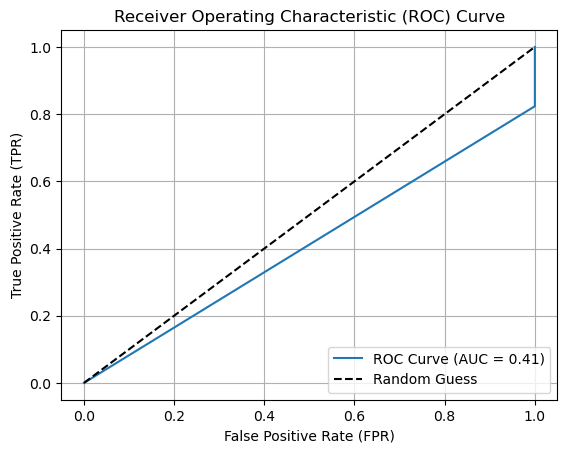

INFO:root:Total parameters: 40834


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1061_ar4.csv
Count of 0's: 87, Count of 1's: 20


100%|██████████| 9/9 [00:00<00:00, 391.50it/s]
INFO:root:Epoch:0, train loss: 16.344952171798248, train accuracy: 0.8, elapsed: 0.030534982681274414 sec.
100%|██████████| 9/9 [00:00<00:00, 409.01it/s]
INFO:root:Epoch:1, train loss: 16.732696869317756, train accuracy: 0.8, elapsed: 0.029003381729125977 sec.
100%|██████████| 9/9 [00:00<00:00, 391.31it/s]
INFO:root:Epoch:2, train loss: 13.60176677092612, train accuracy: 0.8, elapsed: 0.028996944427490234 sec.
100%|██████████| 9/9 [00:00<00:00, 408.90it/s]
INFO:root:Epoch:3, train loss: 13.785932012446453, train accuracy: 0.8, elapsed: 0.028012752532958984 sec.
100%|██████████| 9/9 [00:00<00:00, 460.40it/s]
INFO:root:Epoch:4, train loss: 11.897257951694193, train accuracy: 0.8, elapsed: 0.026549100875854492 sec.
100%|██████████| 9/9 [00:00<00:00, 391.32it/s]
INFO:root:Epoch:5, train loss: 13.743318735075052, train accuracy: 0.7222222222222222, elapsed: 0.030999183654785156 sec.
100%|██████████| 9/9 [00:00<00:00, 428.49it/s]
INFO:root:Epoch

Roc Score Area under the curve 0.9


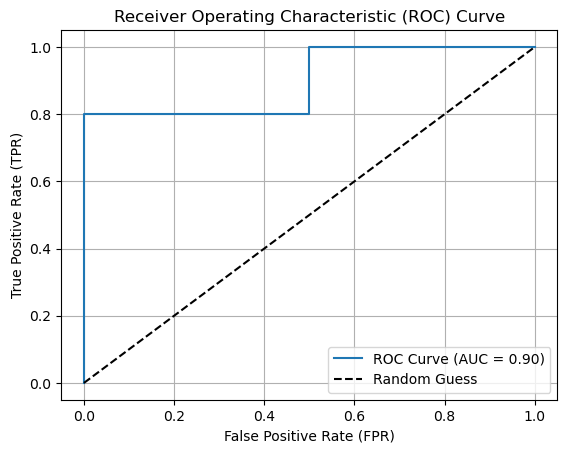

INFO:root:Total parameters: 40834


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1064_ar6.csv
Count of 0's: 86, Count of 1's: 15


100%|██████████| 9/9 [00:00<00:00, 281.16it/s]
INFO:root:Epoch:0, train loss: 17.62860633050312, train accuracy: 0.14117647058823535, elapsed: 0.03200984001159668 sec.
100%|██████████| 9/9 [00:00<00:00, 366.93it/s]
INFO:root:Epoch:1, train loss: 12.44206405298341, train accuracy: 0.8235294117647058, elapsed: 0.03252100944519043 sec.
100%|██████████| 9/9 [00:00<00:00, 562.48it/s]
INFO:root:Epoch:2, train loss: 11.293463677723492, train accuracy: 0.8352941176470589, elapsed: 0.031999826431274414 sec.
100%|██████████| 9/9 [00:00<00:00, 374.97it/s]
INFO:root:Epoch:3, train loss: 12.35773054484697, train accuracy: 0.8352941176470589, elapsed: 0.0240018367767334 sec.
100%|██████████| 9/9 [00:00<00:00, 562.57it/s]
INFO:root:Epoch:4, train loss: 9.310910297192567, train accuracy: 0.8352941176470589, elapsed: 0.03201174736022949 sec.
100%|██████████| 9/9 [00:00<00:00, 449.52it/s]
INFO:root:Epoch:5, train loss: 8.997086259027778, train accuracy: 0.8352941176470589, elapsed: 0.02002120018005371 s

Roc Score Area under the curve 0.26666666666666666


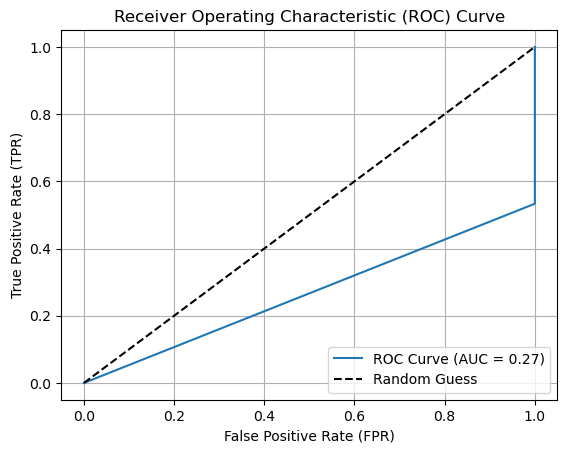

INFO:root:Total parameters: 43394


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_1065_kc3.csv
Count of 0's: 415, Count of 1's: 43


100%|██████████| 39/39 [00:00<00:00, 402.88it/s]
INFO:root:Epoch:0, train loss: 19.098710116080884, train accuracy: 0.9074550128534704, elapsed: 0.10484576225280762 sec.
100%|██████████| 39/39 [00:00<00:00, 320.67it/s]
INFO:root:Epoch:1, train loss: 11.104603647402435, train accuracy: 0.9074550128534704, elapsed: 0.12961745262145996 sec.
100%|██████████| 39/39 [00:00<00:00, 433.79it/s]
INFO:root:Epoch:2, train loss: 10.810918420118618, train accuracy: 0.9074550128534704, elapsed: 0.10591244697570801 sec.
100%|██████████| 39/39 [00:00<00:00, 440.83it/s]
INFO:root:Epoch:3, train loss: 9.909129076888636, train accuracy: 0.9074550128534704, elapsed: 0.1044619083404541 sec.
100%|██████████| 39/39 [00:00<00:00, 438.31it/s]
INFO:root:Epoch:4, train loss: 8.679974119309176, train accuracy: 0.9074550128534704, elapsed: 0.10532402992248535 sec.
100%|██████████| 39/39 [00:00<00:00, 441.20it/s]
INFO:root:Epoch:5, train loss: 8.603081694458277, train accuracy: 0.9074550128534704, elapsed: 0.0963556

Roc Score Area under the curve 0.3467741935483871


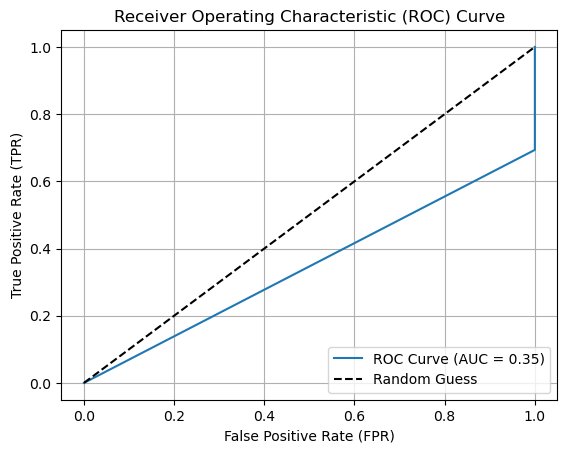

INFO:root:Total parameters: 45954


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_311_oil_spill.csv
Count of 0's: 896, Count of 1's: 41


100%|██████████| 80/80 [00:00<00:00, 331.32it/s]
INFO:root:Epoch:0, train loss: 3.8280477171026006, train accuracy: 0.9597989949748744, elapsed: 0.26598644256591797 sec.
100%|██████████| 80/80 [00:00<00:00, 397.58it/s]
INFO:root:Epoch:1, train loss: 4.072697383233219, train accuracy: 0.9597989949748744, elapsed: 0.22521233558654785 sec.
100%|██████████| 80/80 [00:00<00:00, 382.48it/s]
INFO:root:Epoch:2, train loss: 3.482659953153494, train accuracy: 0.9597989949748744, elapsed: 0.22516846656799316 sec.
100%|██████████| 80/80 [00:00<00:00, 391.78it/s]
INFO:root:Epoch:3, train loss: 3.050925248217111, train accuracy: 0.9597989949748744, elapsed: 0.22838997840881348 sec.
100%|██████████| 80/80 [00:00<00:00, 379.82it/s]
INFO:root:Epoch:4, train loss: 3.2251415069234226, train accuracy: 0.9597989949748744, elapsed: 0.2266676425933838 sec.
100%|██████████| 80/80 [00:00<00:00, 397.62it/s]
INFO:root:Epoch:5, train loss: 3.828048214120541, train accuracy: 0.9597989949748744, elapsed: 0.22619819

Roc Score Area under the curve 0.5


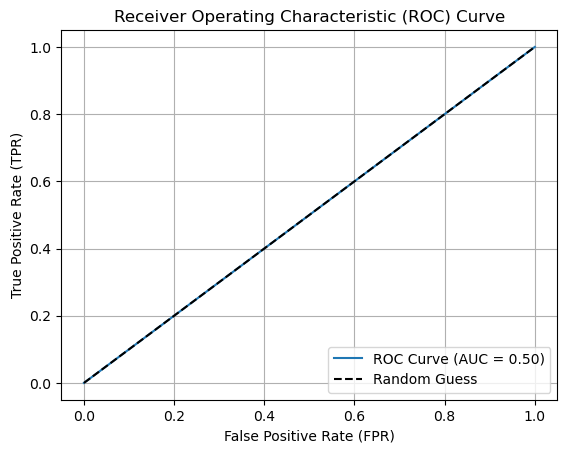

INFO:root:Total parameters: 109954


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_312_scene.csv
Count of 0's: 1976, Count of 1's: 431


100%|██████████| 205/205 [00:01<00:00, 140.74it/s]
INFO:root:Epoch:0, train loss: 0.648877182455501, train accuracy: 0.823960880195599, elapsed: 1.5055880546569824 sec.
100%|██████████| 205/205 [00:01<00:00, 142.42it/s]
INFO:root:Epoch:1, train loss: 0.5195243565249341, train accuracy: 0.823960880195599, elapsed: 1.4889028072357178 sec.
100%|██████████| 205/205 [00:01<00:00, 137.94it/s]
INFO:root:Epoch:2, train loss: 0.4269288030227699, train accuracy: 0.8244498777506113, elapsed: 1.5341341495513916 sec.
100%|██████████| 205/205 [00:01<00:00, 141.43it/s]
INFO:root:Epoch:3, train loss: 0.38717489380248415, train accuracy: 0.8249388753056235, elapsed: 1.4916057586669922 sec.
100%|██████████| 205/205 [00:01<00:00, 141.49it/s]
INFO:root:Epoch:4, train loss: 0.37839815563861107, train accuracy: 0.8268948655256724, elapsed: 1.4918928146362305 sec.
100%|██████████| 205/205 [00:01<00:00, 143.38it/s]
INFO:root:Epoch:5, train loss: 0.35286949194535006, train accuracy: 0.8273838630806846, elapsed

Roc Score Area under the curve 0.927786651178549


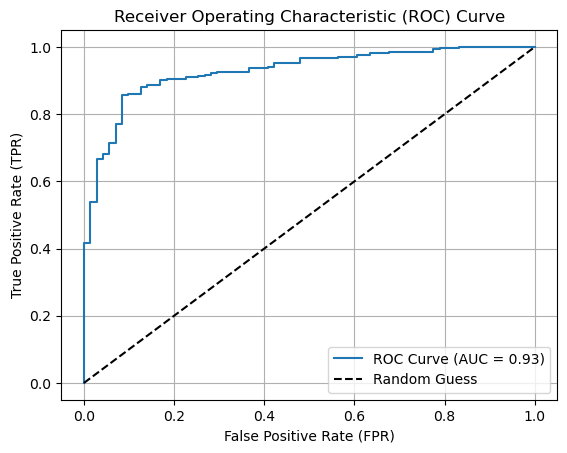

INFO:root:Total parameters: 63106


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_316_yeast_ml8.csv
Count of 0's: 2383, Count of 1's: 34


100%|██████████| 206/206 [00:00<00:00, 270.14it/s]
INFO:root:Epoch:0, train loss: 0.25468956614852467, train accuracy: 0.9844206426484907, elapsed: 0.8589732646942139 sec.
100%|██████████| 206/206 [00:00<00:00, 273.89it/s]
INFO:root:Epoch:1, train loss: 0.09782629251546412, train accuracy: 0.9844206426484907, elapsed: 0.7922990322113037 sec.
100%|██████████| 206/206 [00:00<00:00, 267.59it/s]
INFO:root:Epoch:2, train loss: 0.09044694325949193, train accuracy: 0.9844206426484907, elapsed: 0.8078410625457764 sec.
100%|██████████| 206/206 [00:00<00:00, 271.23it/s]
INFO:root:Epoch:3, train loss: 0.09721703010435116, train accuracy: 0.9844206426484907, elapsed: 0.7975172996520996 sec.
100%|██████████| 206/206 [00:00<00:00, 270.56it/s]
INFO:root:Epoch:4, train loss: 0.09127491477661136, train accuracy: 0.9844206426484907, elapsed: 0.8024084568023682 sec.
100%|██████████| 206/206 [00:00<00:00, 269.86it/s]
INFO:root:Epoch:5, train loss: 0.0913708576345307, train accuracy: 0.9844206426484907, el

Roc Score Area under the curve 0.9584487534626038


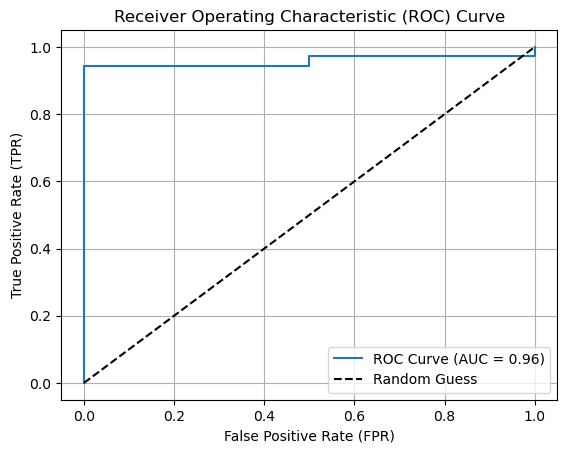

INFO:root:Total parameters: 40834


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_38_sick.csv
Count of 0's: 3541, Count of 1's: 231


  0%|          | 0/321 [00:00<?, ?it/s]
INFO:root:Total parameters: 34434


Erro com dataset_38_sick.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_450_analcatdata_lawsuit.csv
Count of 0's: 245, Count of 1's: 19


100%|██████████| 23/23 [00:00<00:00, 490.07it/s]
INFO:root:Epoch:0, train loss: 1.2241774093257407, train accuracy: 0.9375, elapsed: 0.056946516036987305 sec.
100%|██████████| 23/23 [00:00<00:00, 533.35it/s]
INFO:root:Epoch:1, train loss: 0.6901429404686162, train accuracy: 0.9375, elapsed: 0.05112791061401367 sec.
100%|██████████| 23/23 [00:00<00:00, 511.07it/s]
INFO:root:Epoch:2, train loss: 0.5750870504293008, train accuracy: 0.9375, elapsed: 0.054009199142456055 sec.
100%|██████████| 23/23 [00:00<00:00, 556.95it/s]
INFO:root:Epoch:3, train loss: 0.4939869516626693, train accuracy: 0.9375, elapsed: 0.05035281181335449 sec.
100%|██████████| 23/23 [00:00<00:00, 547.35it/s]
INFO:root:Epoch:4, train loss: 0.7299116187735811, train accuracy: 0.9375, elapsed: 0.049526214599609375 sec.
100%|██████████| 23/23 [00:00<00:00, 546.97it/s]
INFO:root:Epoch:5, train loss: 0.5123349280513134, train accuracy: 0.9375, elapsed: 0.04910397529602051 sec.
100%|██████████| 23/23 [00:00<00:00, 547.40it/s]


Roc Score Area under the curve 0.8799999999999999


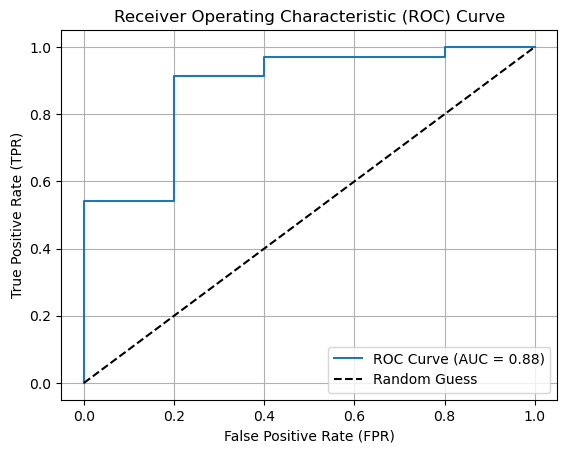

INFO:root:Total parameters: 41346


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_463_backache.csv
Count of 0's: 155, Count of 1's: 25


100%|██████████| 16/16 [00:00<00:00, 380.98it/s]
INFO:root:Epoch:0, train loss: 12.34028526209767, train accuracy: 0.8627450980392157, elapsed: 0.051003456115722656 sec.
100%|██████████| 16/16 [00:00<00:00, 390.12it/s]
INFO:root:Epoch:1, train loss: 5.950592809212552, train accuracy: 0.8627450980392157, elapsed: 0.049767494201660156 sec.
100%|██████████| 16/16 [00:00<00:00, 432.48it/s]
INFO:root:Epoch:2, train loss: 4.307007553881202, train accuracy: 0.8627450980392157, elapsed: 0.04358220100402832 sec.
100%|██████████| 16/16 [00:00<00:00, 432.45it/s]
INFO:root:Epoch:3, train loss: 3.746463713854477, train accuracy: 0.8627450980392157, elapsed: 0.04600787162780762 sec.
100%|██████████| 16/16 [00:00<00:00, 401.53it/s]
INFO:root:Epoch:4, train loss: 4.792783055675561, train accuracy: 0.8627450980392157, elapsed: 0.046846866607666016 sec.
100%|██████████| 16/16 [00:00<00:00, 516.17it/s]
INFO:root:Epoch:5, train loss: 3.3426574506377253, train accuracy: 0.8627450980392157, elapsed: 0.03900

Roc Score Area under the curve 0.15217391304347827


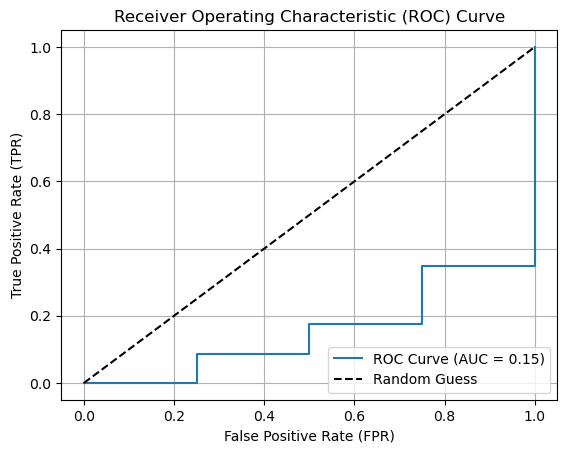

INFO:root:Total parameters: 38786


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_757_meta.csv
Count of 0's: 474, Count of 1's: 54


  0%|          | 0/45 [00:00<?, ?it/s]
INFO:root:Total parameters: 34178


Erro com dataset_757_meta.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_764_analcatdata_apnea3.csv
Count of 0's: 395, Count of 1's: 55


  0%|          | 0/39 [00:00<?, ?it/s]
INFO:root:Total parameters: 34178


Erro com dataset_764_analcatdata_apnea3.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_765_analcatdata_apnea2.csv
Count of 0's: 411, Count of 1's: 64


  0%|          | 0/41 [00:00<?, ?it/s]
INFO:root:Total parameters: 34178


Erro com dataset_765_analcatdata_apnea2.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_767_analcatdata_apnea1.csv
Count of 0's: 414, Count of 1's: 61


  0%|          | 0/41 [00:00<?, ?it/s]
INFO:root:Total parameters: 33922


Erro com dataset_767_analcatdata_apnea1.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_865_analcatdata_neavote.csv
Count of 0's: 93, Count of 1's: 7


  0%|          | 0/9 [00:00<?, ?it/s]
INFO:root:Total parameters: 33922


Erro com dataset_865_analcatdata_neavote.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_867_visualizing_livestock.csv
Count of 0's: 105, Count of 1's: 25


  0%|          | 0/11 [00:00<?, ?it/s]
INFO:root:Total parameters: 34178


Erro com dataset_867_visualizing_livestock.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_875_analcatdata_chlamydia.csv
Count of 0's: 81, Count of 1's: 19


  0%|          | 0/9 [00:00<?, ?it/s]
INFO:root:Total parameters: 42626


Erro com dataset_875_analcatdata_chlamydia.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_940_water-treatment.csv
Count of 0's: 447, Count of 1's: 80


100%|██████████| 45/45 [00:00<00:00, 353.46it/s]
INFO:root:Epoch:0, train loss: nan, train accuracy: 0.8501118568232662, elapsed: 0.13831090927124023 sec.
100%|██████████| 45/45 [00:00<00:00, 502.57it/s]
INFO:root:Epoch:1, train loss: nan, train accuracy: 0.8501118568232662, elapsed: 0.10153889656066895 sec.
100%|██████████| 45/45 [00:00<00:00, 502.46it/s]
INFO:root:Epoch:2, train loss: nan, train accuracy: 0.8501118568232662, elapsed: 0.1035306453704834 sec.
100%|██████████| 45/45 [00:00<00:00, 465.07it/s]
INFO:root:Epoch:3, train loss: nan, train accuracy: 0.8501118568232662, elapsed: 0.10852742195129395 sec.
100%|██████████| 45/45 [00:00<00:00, 459.12it/s]
INFO:root:Epoch:4, train loss: nan, train accuracy: 0.8501118568232662, elapsed: 0.10901165008544922 sec.
100%|██████████| 45/45 [00:00<00:00, 480.98it/s]
INFO:root:Epoch:5, train loss: nan, train accuracy: 0.8501118568232662, elapsed: 0.10553669929504395 sec.
100%|██████████| 45/45 [00:00<00:00, 502.48it/s]
INFO:root:Epoch:6, tra

Erro com dataset_940_water-treatment.csv: Input contains NaN.
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_947_arsenic-male-bladder.csv
Count of 0's: 535, Count of 1's: 24


100%|██████████| 48/48 [00:00<00:00, 536.11it/s]
INFO:root:Epoch:0, train loss: 13.416795612968466, train accuracy: 0.9536842105263158, elapsed: 0.10354995727539062 sec.
100%|██████████| 48/48 [00:00<00:00, 557.88it/s]
INFO:root:Epoch:1, train loss: 6.283480293857433, train accuracy: 0.9536842105263158, elapsed: 0.0985250473022461 sec.
100%|██████████| 48/48 [00:00<00:00, 542.81it/s]
INFO:root:Epoch:2, train loss: 6.762371204890272, train accuracy: 0.9536842105263158, elapsed: 0.09943675994873047 sec.
100%|██████████| 48/48 [00:00<00:00, 542.19it/s]
INFO:root:Epoch:3, train loss: 7.15616932047399, train accuracy: 0.9536842105263158, elapsed: 0.10056018829345703 sec.
100%|██████████| 48/48 [00:00<00:00, 524.42it/s]
INFO:root:Epoch:4, train loss: 6.384499442076252, train accuracy: 0.9536842105263158, elapsed: 0.10351037979125977 sec.
100%|██████████| 48/48 [00:00<00:00, 566.35it/s]
INFO:root:Epoch:5, train loss: 6.953896373985297, train accuracy: 0.9536842105263158, elapsed: 0.0977621078

Roc Score Area under the curve 0.35365853658536583


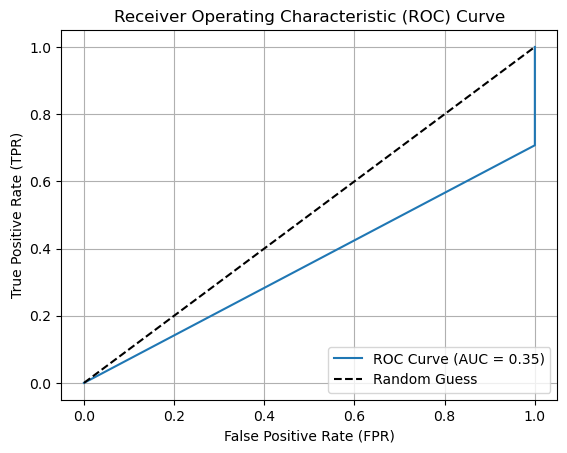

INFO:root:Total parameters: 34434


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_949_arsenic-female-bladder.csv
Count of 0's: 479, Count of 1's: 80


100%|██████████| 48/48 [00:00<00:00, 504.94it/s]
INFO:root:Epoch:0, train loss: 20.830868564768775, train accuracy: 0.871578947368421, elapsed: 0.10906410217285156 sec.
100%|██████████| 48/48 [00:00<00:00, 574.74it/s]
INFO:root:Epoch:1, train loss: 14.471450973190597, train accuracy: 0.8547368421052631, elapsed: 0.09551692008972168 sec.
100%|██████████| 48/48 [00:00<00:00, 536.12it/s]
INFO:root:Epoch:2, train loss: 10.967037767184442, train accuracy: 0.8547368421052631, elapsed: 0.10053610801696777 sec.
100%|██████████| 48/48 [00:00<00:00, 567.81it/s]
INFO:root:Epoch:3, train loss: 11.692806386287629, train accuracy: 0.8547368421052631, elapsed: 0.09653544425964355 sec.
100%|██████████| 48/48 [00:00<00:00, 567.87it/s]
INFO:root:Epoch:4, train loss: 10.733018587887216, train accuracy: 0.8547368421052631, elapsed: 0.09952425956726074 sec.
100%|██████████| 48/48 [00:00<00:00, 554.65it/s]
INFO:root:Epoch:5, train loss: 9.618531735660705, train accuracy: 0.8547368421052631, elapsed: 0.09955

Roc Score Area under the curve 0.46948941469489414


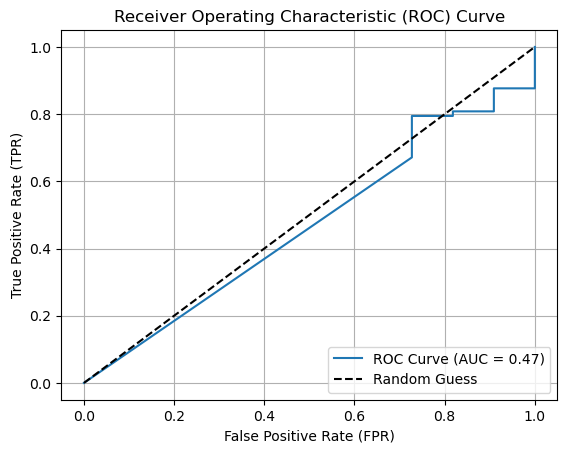

INFO:root:Total parameters: 34434


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_950_arsenic-female-lung.csv
Count of 0's: 540, Count of 1's: 19


100%|██████████| 48/48 [00:00<00:00, 314.18it/s]
INFO:root:Epoch:0, train loss: 10.128454470374118, train accuracy: 0.9642105263157895, elapsed: 0.16229915618896484 sec.
100%|██████████| 48/48 [00:00<00:00, 542.17it/s]
INFO:root:Epoch:1, train loss: 5.683832392914728, train accuracy: 0.9642105263157895, elapsed: 0.09656858444213867 sec.
100%|██████████| 48/48 [00:00<00:00, 598.21it/s]
INFO:root:Epoch:2, train loss: 5.978556239680078, train accuracy: 0.9642105263157895, elapsed: 0.10550999641418457 sec.
100%|██████████| 48/48 [00:00<00:00, 545.40it/s]
INFO:root:Epoch:3, train loss: 6.963504497325499, train accuracy: 0.9642105263157895, elapsed: 0.09644007682800293 sec.
100%|██████████| 48/48 [00:00<00:00, 548.83it/s]
INFO:root:Epoch:4, train loss: 8.939687080639883, train accuracy: 0.9642105263157895, elapsed: 0.10477280616760254 sec.
100%|██████████| 48/48 [00:00<00:00, 545.13it/s]
INFO:root:Epoch:5, train loss: 8.537527454565721, train accuracy: 0.9642105263157895, elapsed: 0.09607958

Roc Score Area under the curve 0.39634146341463417


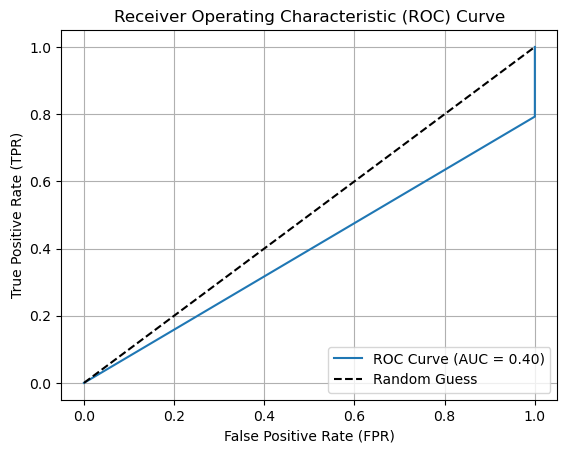

INFO:root:Total parameters: 34434


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_951_arsenic-male-lung.csv
Count of 0's: 546, Count of 1's: 13


100%|██████████| 48/48 [00:00<00:00, 497.77it/s]
INFO:root:Epoch:0, train loss: 5.044666987052325, train accuracy: 0.9726315789473684, elapsed: 0.10855388641357422 sec.
100%|██████████| 48/48 [00:00<00:00, 596.14it/s]
INFO:root:Epoch:1, train loss: 6.697507932101662, train accuracy: 0.9726315789473684, elapsed: 0.08851957321166992 sec.
100%|██████████| 48/48 [00:00<00:00, 540.81it/s]
INFO:root:Epoch:2, train loss: 5.495579633518202, train accuracy: 0.9726315789473684, elapsed: 0.09676122665405273 sec.
100%|██████████| 48/48 [00:00<00:00, 599.59it/s]
INFO:root:Epoch:3, train loss: 5.515137751146365, train accuracy: 0.9094736842105263, elapsed: 0.10405755043029785 sec.
100%|██████████| 48/48 [00:00<00:00, 597.87it/s]
INFO:root:Epoch:4, train loss: 6.054273401915391, train accuracy: 0.8547368421052631, elapsed: 0.0882878303527832 sec.
100%|██████████| 48/48 [00:00<00:00, 457.64it/s]
INFO:root:Epoch:5, train loss: 5.56304565493114, train accuracy: 0.7705263157894737, elapsed: 0.14530396461

Erro com dataset_951_arsenic-male-lung.csv: Only one class present in y_true. ROC AUC score is not defined in that case.
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_954_spectrometer.csv
Count of 0's: 476, Count of 1's: 55


100%|██████████| 46/46 [00:00<00:00, 290.14it/s]
INFO:root:Epoch:0, train loss: 7.583624722057587, train accuracy: 0.893569844789357, elapsed: 0.17181777954101562 sec.
100%|██████████| 46/46 [00:00<00:00, 302.62it/s]
INFO:root:Epoch:1, train loss: 6.743858502388864, train accuracy: 0.893569844789357, elapsed: 0.16401076316833496 sec.
100%|██████████| 46/46 [00:00<00:00, 291.03it/s]
INFO:root:Epoch:2, train loss: 6.982839575492812, train accuracy: 0.893569844789357, elapsed: 0.17106080055236816 sec.
100%|██████████| 46/46 [00:00<00:00, 278.67it/s]
INFO:root:Epoch:3, train loss: 6.292581127758783, train accuracy: 0.893569844789357, elapsed: 0.17907309532165527 sec.
100%|██████████| 46/46 [00:00<00:00, 290.17it/s]
INFO:root:Epoch:4, train loss: 6.081828017364709, train accuracy: 0.893569844789357, elapsed: 0.17153453826904297 sec.
100%|██████████| 46/46 [00:00<00:00, 280.41it/s]
INFO:root:Epoch:5, train loss: 4.880479273198815, train accuracy: 0.893569844789357, elapsed: 0.177045583724975

Roc Score Area under the curve 0.5714285714285714


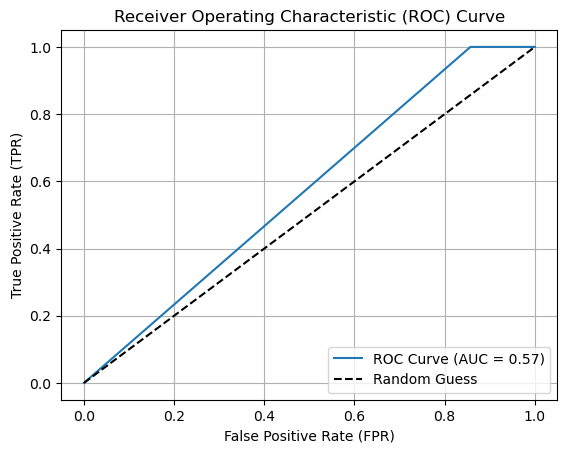

INFO:root:Total parameters: 38274


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_958_segment.csv
Count of 0's: 1980, Count of 1's: 330


100%|██████████| 197/197 [00:00<00:00, 360.77it/s]
INFO:root:Epoch:0, train loss: 5.229375018663054, train accuracy: 0.8522669383596536, elapsed: 0.5820538997650146 sec.
100%|██████████| 197/197 [00:00<00:00, 492.85it/s]
INFO:root:Epoch:1, train loss: 3.8160201946766876, train accuracy: 0.8522669383596536, elapsed: 0.4367196559906006 sec.
100%|██████████| 197/197 [00:00<00:00, 476.28it/s]
INFO:root:Epoch:2, train loss: 3.2169362626842553, train accuracy: 0.8522669383596536, elapsed: 0.4496481418609619 sec.
100%|██████████| 197/197 [00:00<00:00, 498.49it/s]
INFO:root:Epoch:3, train loss: 3.029412117467003, train accuracy: 0.8675496688741722, elapsed: 0.4343101978302002 sec.
100%|██████████| 197/197 [00:00<00:00, 489.18it/s]
INFO:root:Epoch:4, train loss: 2.6865629250514234, train accuracy: 0.8767193071828834, elapsed: 0.44224071502685547 sec.
100%|██████████| 197/197 [00:00<00:00, 517.80it/s]
INFO:root:Epoch:5, train loss: 2.679832583986646, train accuracy: 0.8904737646459501, elapsed: 

Roc Score Area under the curve 0.9820846905537459


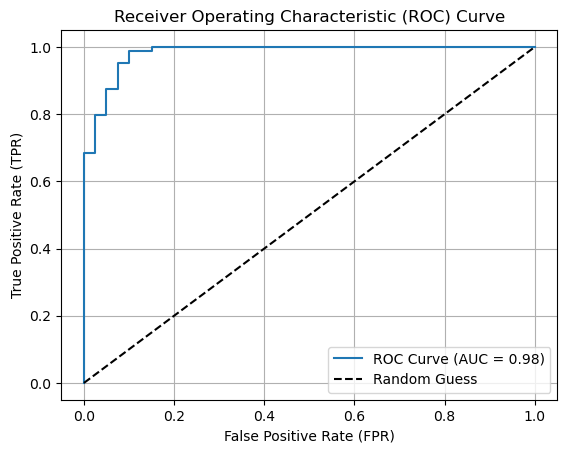

INFO:root:Total parameters: 34946


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_962_mfeat-morphological.csv
Count of 0's: 1800, Count of 1's: 200


100%|██████████| 170/170 [00:00<00:00, 569.33it/s]
INFO:root:Epoch:0, train loss: 5.474823981628354, train accuracy: 0.8952941176470588, elapsed: 0.3387479782104492 sec.
100%|██████████| 170/170 [00:00<00:00, 600.11it/s]
INFO:root:Epoch:1, train loss: 4.667619782244167, train accuracy: 0.8952941176470588, elapsed: 0.3072926998138428 sec.
100%|██████████| 170/170 [00:00<00:00, 566.07it/s]
INFO:root:Epoch:2, train loss: 4.530032660159596, train accuracy: 0.8952941176470588, elapsed: 0.3293278217315674 sec.
100%|██████████| 170/170 [00:00<00:00, 499.14it/s]
INFO:root:Epoch:3, train loss: 4.629912406709753, train accuracy: 0.8952941176470588, elapsed: 0.3731193542480469 sec.
100%|██████████| 170/170 [00:00<00:00, 557.68it/s]
INFO:root:Epoch:4, train loss: 4.743550011871836, train accuracy: 0.8952941176470588, elapsed: 0.33682894706726074 sec.
100%|██████████| 170/170 [00:00<00:00, 567.41it/s]
INFO:root:Epoch:5, train loss: 4.591708403151351, train accuracy: 0.8952941176470588, elapsed: 0.3

Roc Score Area under the curve 0.5


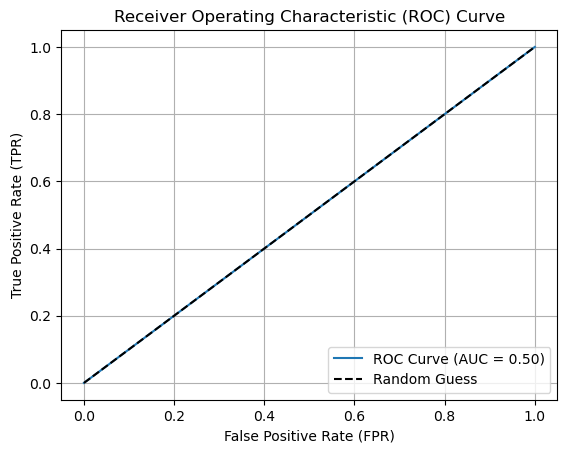

INFO:root:Total parameters: 37506


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_966_analcatdata_halloffame.csv
Count of 0's: 1215, Count of 1's: 125


  0%|          | 0/114 [00:00<?, ?it/s]
INFO:root:Total parameters: 34178


Erro com dataset_966_analcatdata_halloffame.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_968_analcatdata_birthday.csv
Count of 0's: 312, Count of 1's: 53


  0%|          | 0/31 [00:00<?, ?it/s]
INFO:root:Total parameters: 52866


Erro com dataset_968_analcatdata_birthday.csv: can't multiply sequence by non-int of type 'float'
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_971_mfeat-fourier.csv
Count of 0's: 1800, Count of 1's: 200


100%|██████████| 170/170 [00:00<00:00, 274.01it/s]
INFO:root:Epoch:0, train loss: 0.5416422726726637, train accuracy: 0.8952941176470588, elapsed: 0.6532673835754395 sec.
100%|██████████| 170/170 [00:00<00:00, 345.00it/s]
INFO:root:Epoch:1, train loss: 0.38334930228700964, train accuracy: 0.8952941176470588, elapsed: 0.5335867404937744 sec.
100%|██████████| 170/170 [00:00<00:00, 343.78it/s]
INFO:root:Epoch:2, train loss: 0.34618758931216004, train accuracy: 0.8952941176470588, elapsed: 0.5270233154296875 sec.
100%|██████████| 170/170 [00:00<00:00, 317.81it/s]
INFO:root:Epoch:3, train loss: 0.3461088889057506, train accuracy: 0.8952941176470588, elapsed: 0.5649309158325195 sec.
100%|██████████| 170/170 [00:00<00:00, 337.92it/s]
INFO:root:Epoch:4, train loss: 0.3068428558231527, train accuracy: 0.8952941176470588, elapsed: 0.5350751876831055 sec.
100%|██████████| 170/170 [00:00<00:00, 336.64it/s]
INFO:root:Epoch:5, train loss: 0.3257480285228967, train accuracy: 0.8952941176470588, elaps

Roc Score Area under the curve 1.0


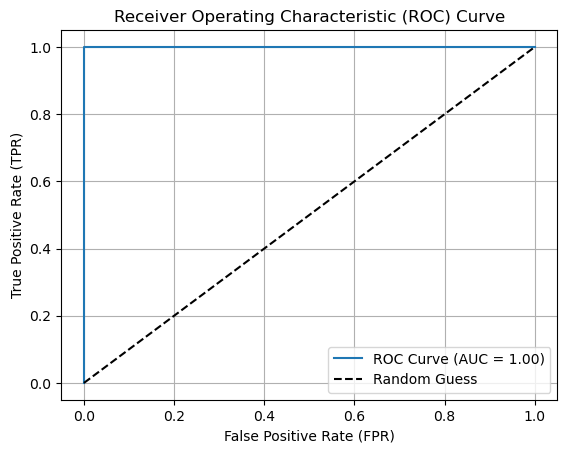

INFO:root:Total parameters: 36994


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_976_JapaneseVowels.csv
Count of 0's: 8347, Count of 1's: 1614


100%|██████████| 847/847 [00:01<00:00, 516.91it/s]
INFO:root:Epoch:0, train loss: 1.143226540997641, train accuracy: 0.8440822111977321, elapsed: 1.760662317276001 sec.
100%|██████████| 847/847 [00:01<00:00, 524.34it/s]
INFO:root:Epoch:1, train loss: 0.6776329597628173, train accuracy: 0.8394755492558469, elapsed: 1.7381112575531006 sec.
100%|██████████| 847/847 [00:01<00:00, 531.81it/s]
INFO:root:Epoch:2, train loss: 0.5959009455873868, train accuracy: 0.8407748641625324, elapsed: 1.7214279174804688 sec.
100%|██████████| 847/847 [00:01<00:00, 478.84it/s]
INFO:root:Epoch:3, train loss: 0.5285186170028414, train accuracy: 0.8619182612804158, elapsed: 1.926710605621338 sec.
100%|██████████| 847/847 [00:01<00:00, 499.25it/s]
INFO:root:Epoch:4, train loss: 0.4680151544408883, train accuracy: 0.871367824238129, elapsed: 1.8354735374450684 sec.
100%|██████████| 847/847 [00:01<00:00, 520.52it/s]
INFO:root:Epoch:5, train loss: 0.43144016374699956, train accuracy: 0.8573115993385306, elapsed: 1

Roc Score Area under the curve 0.8527387729285263


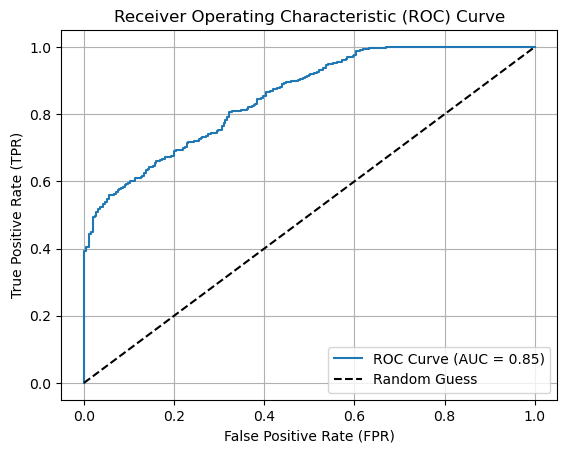

INFO:root:Total parameters: 88706


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_978_mfeat-factors.csv
Count of 0's: 1800, Count of 1's: 200


100%|██████████| 170/170 [00:00<00:00, 188.36it/s]
INFO:root:Epoch:0, train loss: 8.75605954315888, train accuracy: 0.8952941176470588, elapsed: 0.9394891262054443 sec.
100%|██████████| 170/170 [00:00<00:00, 184.48it/s]
INFO:root:Epoch:1, train loss: 5.82492289840973, train accuracy: 0.8952941176470588, elapsed: 0.9568889141082764 sec.
100%|██████████| 170/170 [00:00<00:00, 187.50it/s]
INFO:root:Epoch:2, train loss: 5.782305473010694, train accuracy: 0.8952941176470588, elapsed: 0.9456605911254883 sec.
100%|██████████| 170/170 [00:00<00:00, 188.83it/s]
INFO:root:Epoch:3, train loss: 5.509841785802582, train accuracy: 0.8952941176470588, elapsed: 0.938270092010498 sec.
100%|██████████| 170/170 [00:00<00:00, 191.66it/s]
INFO:root:Epoch:4, train loss: 4.863096289757946, train accuracy: 0.8952941176470588, elapsed: 0.9260272979736328 sec.
100%|██████████| 170/170 [00:00<00:00, 191.77it/s]
INFO:root:Epoch:5, train loss: 4.764198427250108, train accuracy: 0.8952941176470588, elapsed: 0.93036

Roc Score Area under the curve 0.8624100719424461


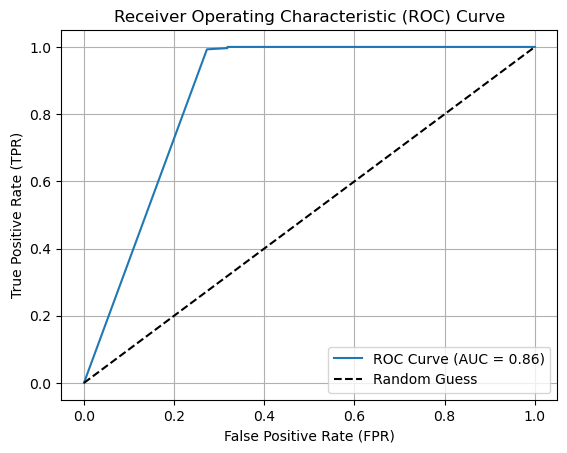

INFO:root:Total parameters: 49794


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_980_optdigits.csv
Count of 0's: 5048, Count of 1's: 572


100%|██████████| 478/478 [00:01<00:00, 364.42it/s]
INFO:root:Epoch:0, train loss: 1.370363019330748, train accuracy: 0.9214988486497802, elapsed: 1.4002296924591064 sec.
100%|██████████| 478/478 [00:01<00:00, 369.12it/s]
INFO:root:Epoch:1, train loss: 0.5899840784331563, train accuracy: 0.9648314841951016, elapsed: 1.38676118850708 sec.
100%|██████████| 478/478 [00:01<00:00, 365.03it/s]
INFO:root:Epoch:2, train loss: 0.43380647566100117, train accuracy: 0.9780196776219384, elapsed: 1.3910388946533203 sec.
100%|██████████| 478/478 [00:01<00:00, 373.12it/s]
INFO:root:Epoch:3, train loss: 0.3377678910793327, train accuracy: 0.9809503872723466, elapsed: 1.3676412105560303 sec.
100%|██████████| 478/478 [00:01<00:00, 369.02it/s]
INFO:root:Epoch:4, train loss: 0.264780644610463, train accuracy: 0.986811806573163, elapsed: 1.3768641948699951 sec.
100%|██████████| 478/478 [00:01<00:00, 368.99it/s]
INFO:root:Epoch:5, train loss: 0.2605336089238047, train accuracy: 0.9832530877119531, elapsed: 1.

Roc Score Area under the curve 0.98878062169766


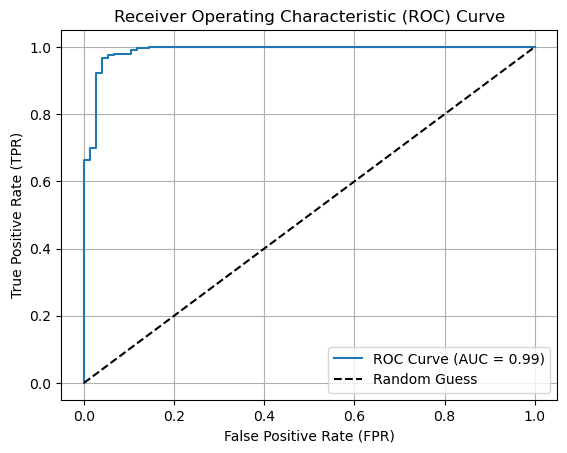

INFO:root:Total parameters: 34434


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_984_analcatdata_draft.csv
Count of 0's: 334, Count of 1's: 32


100%|██████████| 32/32 [00:00<00:00, 327.11it/s]
INFO:root:Epoch:0, train loss: nan, train accuracy: 0.9067524115755627, elapsed: 0.11136436462402344 sec.
100%|██████████| 32/32 [00:00<00:00, 578.85it/s]
INFO:root:Epoch:1, train loss: nan, train accuracy: 0.9067524115755627, elapsed: 0.06328845024108887 sec.
100%|██████████| 32/32 [00:00<00:00, 566.09it/s]
INFO:root:Epoch:2, train loss: nan, train accuracy: 0.9067524115755627, elapsed: 0.06553173065185547 sec.
100%|██████████| 32/32 [00:00<00:00, 603.63it/s]
INFO:root:Epoch:3, train loss: nan, train accuracy: 0.9067524115755627, elapsed: 0.06400609016418457 sec.
100%|██████████| 32/32 [00:00<00:00, 558.50it/s]
INFO:root:Epoch:4, train loss: nan, train accuracy: 0.9067524115755627, elapsed: 0.06781554222106934 sec.
100%|██████████| 32/32 [00:00<00:00, 591.68it/s]
INFO:root:Epoch:5, train loss: nan, train accuracy: 0.9067524115755627, elapsed: 0.06410980224609375 sec.
100%|██████████| 32/32 [00:00<00:00, 603.15it/s]
INFO:root:Epoch:6, tr

Erro com dataset_984_analcatdata_draft.csv: Input contains NaN.
c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_987_collins.csv
Count of 0's: 420, Count of 1's: 80


100%|██████████| 43/43 [00:00<00:00, 459.55it/s]
INFO:root:Epoch:0, train loss: 8.78711446964292, train accuracy: 0.8329411764705883, elapsed: 0.10356473922729492 sec.
100%|██████████| 43/43 [00:00<00:00, 524.36it/s]
INFO:root:Epoch:1, train loss: 7.12529634669146, train accuracy: 0.8329411764705883, elapsed: 0.09252262115478516 sec.
100%|██████████| 43/43 [00:00<00:00, 499.91it/s]
INFO:root:Epoch:2, train loss: 7.42012814838662, train accuracy: 0.8329411764705883, elapsed: 0.09759283065795898 sec.
100%|██████████| 43/43 [00:00<00:00, 477.74it/s]
INFO:root:Epoch:3, train loss: 6.8988939230132935, train accuracy: 0.8329411764705883, elapsed: 0.10014081001281738 sec.
100%|██████████| 43/43 [00:00<00:00, 469.84it/s]
INFO:root:Epoch:4, train loss: 6.977568847355052, train accuracy: 0.8329411764705883, elapsed: 0.10252690315246582 sec.
100%|██████████| 43/43 [00:00<00:00, 511.77it/s]
INFO:root:Epoch:5, train loss: 6.581773611229762, train accuracy: 0.8329411764705883, elapsed: 0.09554672241

Roc Score Area under the curve 0.3484848484848485


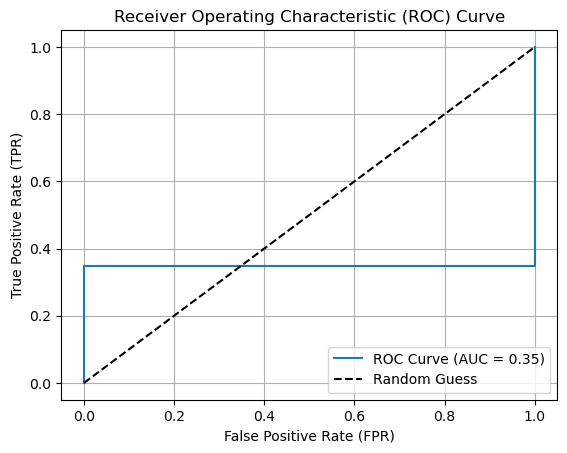

INFO:root:Total parameters: 45442


c:\Users\afora\OneDrive\Documentos\GitHub\Benchmarking-ML-Algorithms-\class_imbalance\class_imbalance\dataset_995_mfeat-zernike.csv
Count of 0's: 1800, Count of 1's: 200


100%|██████████| 170/170 [00:00<00:00, 382.62it/s]
INFO:root:Epoch:0, train loss: 6.08116072782341, train accuracy: 0.8952941176470588, elapsed: 0.4743077754974365 sec.
100%|██████████| 170/170 [00:00<00:00, 411.82it/s]
INFO:root:Epoch:1, train loss: 4.289612158444573, train accuracy: 0.91, elapsed: 0.4458022117614746 sec.
100%|██████████| 170/170 [00:00<00:00, 410.78it/s]
INFO:root:Epoch:2, train loss: 3.0747608013012253, train accuracy: 0.961764705882353, elapsed: 0.4483976364135742 sec.
100%|██████████| 170/170 [00:00<00:00, 423.05it/s]
INFO:root:Epoch:3, train loss: 2.871050599018947, train accuracy: 0.9788235294117648, elapsed: 0.4340665340423584 sec.
100%|██████████| 170/170 [00:00<00:00, 413.99it/s]
INFO:root:Epoch:4, train loss: 2.7382008700832525, train accuracy: 0.9835294117647059, elapsed: 0.43467211723327637 sec.
100%|██████████| 170/170 [00:00<00:00, 430.72it/s]
INFO:root:Epoch:5, train loss: 2.009712579713138, train accuracy: 0.9894117647058823, elapsed: 0.427010297775268

Roc Score Area under the curve 0.9772727272727273


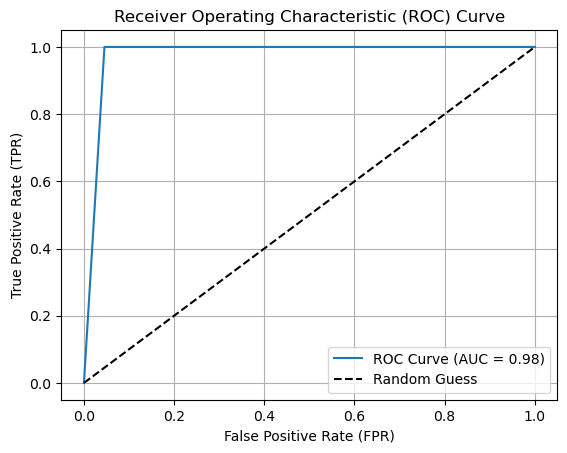

In [ ]:
import logging

from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mla.metrics.metrics import mean_squared_error
from mla.neuralnet import NeuralNet
from mla.neuralnet.constraints import MaxNorm
from mla.neuralnet.layers import Activation, Dense, Dropout
from mla.neuralnet.optimizers import Adadelta, Adam
from mla.neuralnet.parameters import Parameters
from mla.neuralnet.regularizers import L2
from mla.utils import one_hot
import pandas as pd
from mla.neuralnet.layers.recurrent import LSTM, RNN
logging.basicConfig(level=logging.DEBUG)
import os
import numpy as np

def classification(dataset_path):
    data = pd.read_csv(dataset_path)
    
    # Supondo que o dataset tenha colunas 'features' e 'target'
    X = data.iloc[:, :-1].values  # Todas as colunas menos a última como features
    y = data.iloc[:, -1].values   # Última coluna como target

    values, counts = np.unique(y, return_counts=True)
    majority_ratio = counts.max() / counts.sum()

    if len(values) != 2:
        raise ValueError("A coluna target não é binária")

    if majority_ratio <= 0.6:
        raise ValueError("Nenhuma classe é majoritária (>60%)")

    majority_class = values[np.argmax(counts)]
    minority_class = values[np.argmin(counts)]

    # Re-encode: majority -> 0, minority -> 1
    y = np.where(y == majority_class, 0, 1)

    print(dataset_path)
    # Count the occurrences of 0's and 1's in the target column
    count_zeros = np.sum(y == 0)
    count_ones = np.sum(y == 1)
    print(f"Count of 0's: {count_zeros}, Count of 1's: {count_ones}")


    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    #
    y = one_hot(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1111)

    model = NeuralNet(
        layers=[
            Dense(256, Parameters(init="uniform", regularizers={"W": L2(0.05)})),
            Activation("relu"),
            Dropout(0.5),
            Dense(128, Parameters(init="normal", constraints={"W": MaxNorm()})),
            Activation("relu"),
            Dense(2),
            Activation("softmax"),
        ],
        loss="categorical_crossentropy",
        optimizer=Adadelta(),
        metric="accuracy",
        batch_size=64,
        max_epochs=25,
        testarerros=True
    )
    model.fit(X_train, y_train,X_test,y_test)
    predictions = model.predict(X_test)
    auc_score = roc_auc_score(y_test[:, 0], predictions[:, 0])  # Calculate AUC
    
    print("Roc Score Area under the curve", auc_score)
    fpr, tpr, thresholds = roc_curve(y_test[:, 0], predictions[:, 0])

    # Plot FPR vs TPR
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(auc_score))  # Use AUC score here
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


def regression():
    # Generate a random regression problem
    X, y = make_regression(n_samples=5000, n_features=25, n_informative=25, n_targets=1, random_state=100, noise=0.05)
    y *= 0.01
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1111)

    model = NeuralNet(
        layers=[
            Dense(64, Parameters(init="normal")),
            Activation("linear"),
            Dense(32, Parameters(init="normal")),
            Activation("linear"),
            Dense(1),
        ],
        loss="mse",
        optimizer=Adam(),
        metric="mse",
        batch_size=256,
        max_epochs=15,
    )
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("regression mse", mean_squared_error(y_test, predictions.flatten()))



cwd = os.getcwd()  # Obtém o diretório atual
dataset_dir = os.path.join(cwd, "class_imbalance\class_imbalance")  # Caminho relativo corrigido

for filename in os.listdir(dataset_dir):
    if filename.endswith(".csv"):
        dataset_path = os.path.join(dataset_dir, filename)
        try:
            classification(dataset_path)
        except Exception as e:
            print(f"Erro com {filename}: {e}")